In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pmdarima as pm
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [2]:
btc = yf.download(tickers = 'BTC-USD')[['Close']]
btc.index = pd.DatetimeIndex(btc.index.values, freq = btc.index.inferred_freq)

[*********************100%***********************]  1 of 1 completed


In [3]:
btc.head()

,Close
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


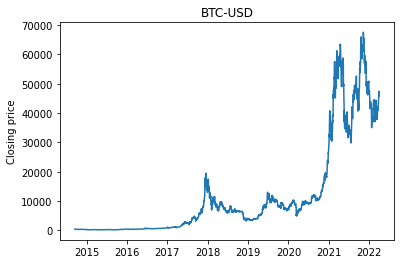

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [5]:
# Let's consider only data since Jan 2021 only
idx_todrop = pd.date_range(start = btc.iloc[0].name.date(), end = '2020-12-31')
btc.drop(idx_todrop, inplace=True)

C:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
btc.head()

,Close
2021-01-01,29374.152344
2021-01-02,32127.267578
2021-01-03,32782.023438
2021-01-04,31971.914062
2021-01-05,33992.429688


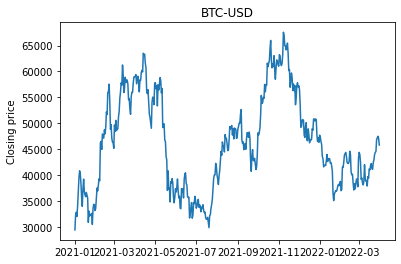

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [10]:
# CHECK STATIONARITY
# From the graph above, we can definitely conclude that there is no stationarity.
# Let's confirm this with ADFULLER and KPSS tests.

# ADFULLER
result = adfuller(btc.Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -2.52
5% Critical Value: -2.87
p-value: 0.11


p-value of 0.11: the time series is not stationary.

In [11]:
# KPSS
from statsmodels.tsa.stattools import kpss

result = kpss(btc.Close)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(0.20294180919911653, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.20
5% Critical Value: 0.46
p-value: 0.10


C:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [12]:
# p-value above 0.10: the time series is stationary.

# KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary.
# Trend needs to be removed to make series strict stationary. 
# Let's create a function to make the time series stationary.

def make_stationary(time_series, diff_depth = 10):
    for i in range(1, diff_depth+1):
        time_series_stationary = time_series.diff(periods = i).dropna()
        if (adfuller(time_series_stationary)[1] < 0.05) and (kpss(time_series_stationary)[1] > 0.05):
            print(f'Stationary time series found with differenciating depth of {i}.')
            return time_series_stationary
    return None

btc['Close_stationary'] = make_stationary(btc.Close)

if not btc.Close_stationary.any():
    print('Please increase depth of differenciation.')

Stationary time series found with differenciating depth of 1.


C:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\Vito\AppData\Local\Temp\ipykernel_14524\1061917828.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Close_stationary'] = make_stationary(btc.Close)


In [13]:
btc.head()

,Close,Close_stationary
2021-01-01,29374.152344,NaN
2021-01-02,32127.267578,2753.115234
2021-01-03,32782.023438,654.755859
2021-01-04,31971.914062,-810.109375
2021-01-05,33992.429688,2020.515625


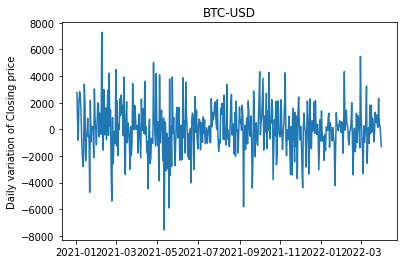

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close_stationary', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Daily variation of Closing price')
plt.show()

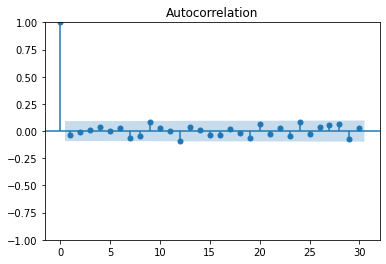

In [15]:
# CHECK AUTO-CORRELATION

# Calculate the ACF (via statsmodel)
plot_acf(btc.Close_stationary.dropna(), alpha =0.05, lags=30)
# Show the data as a plot (via matplotlib)
plt.show()

No auto-correlation of the stationary time series

C:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


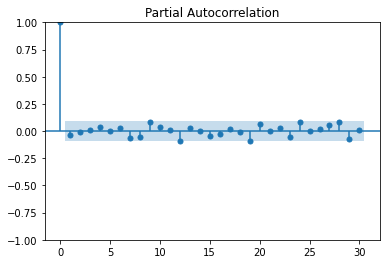

In [16]:
# PARTIAL AUTO-CORRELATION
plot_pacf(btc.Close_stationary.dropna(), alpha =0.05, lags= 30)
plt.show()

No partial auto-correlation of the stationary time series

In [17]:
# The time series is now stationary and not auto-correlated, we can implement AR and MA models



def implement_arima_model(data, order):
    model = ARIMA(data, order = order, freq = 'D')
    results = model.fit()
    p = order[0]
    d = order[1]
    q = order[2]
    y_true = data.values
    y_pred = results.predict(n_periods = len(data))
    if p>0:
        if q>0:
            if d>0:
                model_name = f'ARIMA({p},{d},{q})'
            else:
                model_name = f'ARMA({p},{q})'
        else:
            model_name = f'AR({p})'
    else:
        model_name = f'MA({q})'
    MAE = metrics.mean_absolute_error(y_true=y_true, y_pred = y_pred)
    MAPE = metrics.mean_absolute_percentage_error(y_true=y_true, y_pred = y_pred)
    MSE = metrics.mean_squared_error(y_true=y_true, y_pred = y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred = y_pred))
    NRMSE = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred = y_pred)) / (np.max(y_true) - np.min(y_true))
    AIC = results.aic
    BIC = results.bic
    return [model_name, MAE, MAPE, MSE, RMSE, NRMSE, AIC, BIC]
    
cols = ['MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'AIC', 'BIC']

df_model_comparison = pd.DataFrame(columns = cols)

# AR(1) to AR(3)
for p in range(1,3+1):
    model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (p,0,0))
    df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
    df_model_comparison = pd.concat([df_model_comparison, df_results])

# MA(1) to MA(3)
for q in range(1,3+1):
    model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (0,0,q))
    df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
    df_model_comparison = pd.concat([df_model_comparison, df_results])

# ARMA(1,1) to ARMA(3,3)
for p in range(1, 3+1):
    for q in range(1,3+1):
        model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (p,0,q))
        df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
        df_model_comparison = pd.concat([df_model_comparison, df_results])

df_model_comparison

C:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,MAE,MAPE,MSE,RMSE,NRMSE,AIC,BIC
AR(1),1336.683096,1.016074,3.311080e+06,1819.637320,0.122559,8110.201002,8122.555293
AR(2),1335.935209,1.031238,3.310933e+06,1819.596980,0.122556,8112.179341,8128.651729
AR(3),1335.748862,1.030686,3.310802e+06,1819.560943,0.122554,8114.161415,8134.751901
MA(1),1336.542234,1.018808,3.311040e+06,1819.626445,0.122558,8110.193951,8122.548242
MA(2),1336.051043,1.028898,3.310960e+06,1819.604445,0.122557,8112.184220,8128.656609
MA(3),1335.667603,1.031248,3.310686e+06,1819.528953,0.122551,8114.174146,8134.764632
"ARMA(1,1)",1336.268078,1.024121,3.310994e+06,1819.613769,0.122557,8112.187632,8128.660020
"ARMA(1,2)",1336.002507,1.029741,3.310948e+06,1819.601001,0.122556,8114.182505,8134.772991
"ARMA(1,3)",1336.047905,1.046924,3.309939e+06,1819.323647,0.122538,8116.076167,8140.784750
"ARMA(2,1)",1336.550728,1.062085,3.310727e+06,1819.540428,0.122552,8114.150862,8134.741348


In [18]:
# ARIMA: using auto_arima

model = pm.arima.auto_arima(btc.Close, trace = True, error_action='ignore', suppress_warnings=True, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8137.999, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11085.393, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8136.714, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9981.932, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8135.167, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8136.584, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8130.098, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9098.781, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8128.453, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9599.578, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8130.076, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8131.

In [19]:
model.fit(btc.Close)

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  455
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4061.226
Date:                Thu, 31 Mar 2022   AIC                           8128.453
Time:                        21:35:08   BIC                           8140.813
Sample:                             0   HQIC                          8133.322
                                - 455                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1112.5984    368.142      3.022      0.003     391.053    1834.144
ar.L1          0.9755      0.008    119.123      0.000       0.959       0.992
sigma2      3.269e+06      0.063   5.15e+07      0.000    3.27e+06    3.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                37.56
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.32e+27. Standard errors may be unstable.
"""

In [21]:
forecast = model.predict(n_periods = 5)
forecast = pd.DataFrame(forecast, columns = ['Prediction'])
forecast.set_index(pd.date_range(start = btc.iloc[-1].name.date() + pd.DateOffset(1), end = btc.iloc[-1].name.date() + pd.DateOffset(5)), inplace = True)
forecast

,Prediction
2022-04-01,45757.320950
2022-04-02,45747.627809
2022-04-03,45738.172412
2022-04-04,45728.948928
2022-04-05,45719.951668


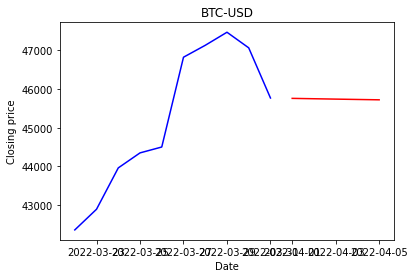

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
btc_zoom = btc.tail(10)
sns.lineplot(x = btc_zoom.index, y='Close', data = btc_zoom, ax = ax, color = "blue")
sns.lineplot(x = forecast.index , y = 'Prediction', data = forecast, ax = ax, color = "red")
ax.set_title('BTC-USD')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price')
plt.show()

According to the (not great) model, BTC price is likely to decrease, so I should not buy BTC now.